<a href="https://colab.research.google.com/github/Aravindan98/DeepGalerkin-FourierNeural/blob/main/American_Options.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pwd
!git clone https://github.com/alialaradi/DeepGalerkinMethod
%cd DeepGalerkinMethod

/content
Cloning into 'DeepGalerkinMethod'...
remote: Enumerating objects: 19, done.
remote: Total 19 (delta 0), reused 0 (delta 0), pack-reused 19
Unpacking objects: 100% (19/19), done.
/content/DeepGalerkinMethod


1.15.2
494.79202 20.10839 0.2288823 243.81726 230.63748 0
427.8385 8.743449 0.34532347 206.81003 211.93971 1
319.74982 7.7294397 0.58063155 174.05473 137.38503 2
258.94632 6.6826487 0.51122355 143.14195 108.61048 3
217.3492 8.188805 0.5825166 108.833206 99.74467 4
159.74294 9.625463 1.442393 99.205376 49.469707 5
157.14291 9.218315 2.607837 66.864845 78.45193 6
115.54088 9.76766 2.9661298 56.143818 46.663273 7
110.19438 9.107115 3.3232315 34.10843 63.6556 8
48.800667 7.0302896 3.22666 14.332405 24.21131 9
55.667217 6.4619265 3.0312889 15.385908 30.788094 10
34.80585 3.746827 2.2807217 22.191614 6.586688 11
28.687103 2.5868044 1.3993315 15.9322815 8.768686 12
19.474688 1.7051306 0.7251815 12.405875 4.6385 13
26.78213 1.1549413 0.2449595 6.024724 19.357504 14
12.805805 0.9014966 0.12258014 4.304499 7.477229 15
28.855375 0.8008234 0.12287811 9.818027 18.113647 16
11.316164 0.59114647 0.08579819 4.690716 5.948504 17
7.1255465 0.42893353 0.044474676 4.984357 1.6677815 18
6.111644 0.42008373

<Figure size 432x288 with 0 Axes>

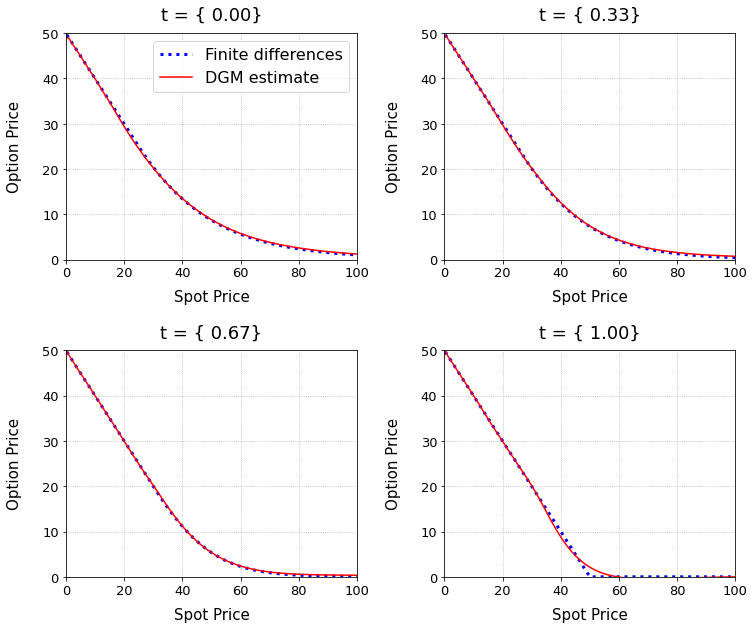

<Figure size 432x288 with 0 Axes>

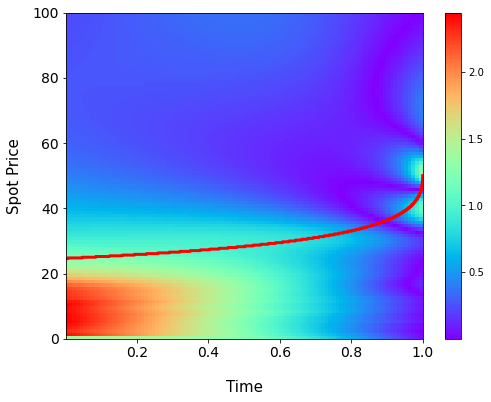

In [ ]:
# SCRIPT FOR SOLVING THE BLACK-SCHOLES EQUATION FOR A EUROPEAN CALL OPTION 

#%% import needed packages

%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
import numpy as np
import scipy.stats as spstats
import matplotlib.pyplot as plt

import tensorflow as tf

#%% LSTM-like layer used in DGM (see Figure 5.3 and set of equations on p. 45) - modification of Keras layer class

class LSTMLayer(tf.keras.layers.Layer):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, output_dim, input_dim, trans1 = "tanh", trans2 = "tanh"):
        '''
        Args:
            input_dim (int):       dimensionality of input data
            output_dim (int):      number of outputs for LSTM layers
            trans1, trans2 (str):  activation functions used inside the layer; 
                                   one of: "tanh" (default), "relu" or "sigmoid"
        
        Returns: customized Keras layer object used as intermediate layers in DGM
        '''        
        
        # create an instance of a Layer object (call initialize function of superclass of LSTMLayer)
        super(LSTMLayer, self).__init__()
        
        # add properties for layer including activation functions used inside the layer  
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        if trans1 == "tanh":
            self.trans1 = tf.nn.tanh
        elif trans1 == "relu":
            self.trans1 = tf.nn.relu
        elif trans1 == "sigmoid":
            self.trans1 = tf.nn.sigmoid
        
        if trans2 == "tanh":
            self.trans2 = tf.nn.tanh
        elif trans2 == "relu":
            self.trans2 = tf.nn.relu
        elif trans2 == "sigmoid":
            self.trans2 = tf.nn.relu
        
        ### define LSTM layer parameters (use Xavier initialization)
        # u vectors (weighting vectors for inputs original inputs x)
        self.Uz = self.add_variable("Uz", shape=[self.input_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Ug = self.add_variable("Ug", shape=[self.input_dim ,self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Ur = self.add_variable("Ur", shape=[self.input_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Uh = self.add_variable("Uh", shape=[self.input_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        
        # w vectors (weighting vectors for output of previous layer)        
        self.Wz = self.add_variable("Wz", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Wg = self.add_variable("Wg", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Wr = self.add_variable("Wr", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Wh = self.add_variable("Wh", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        
        # bias vectors
        self.bz = self.add_variable("bz", shape=[1, self.output_dim])
        self.bg = self.add_variable("bg", shape=[1, self.output_dim])
        self.br = self.add_variable("br", shape=[1, self.output_dim])
        self.bh = self.add_variable("bh", shape=[1, self.output_dim])
    
    
    # main function to be called 
    def call(self, S, X):
        '''Compute output of a LSTMLayer for a given inputs S,X .    

        Args:            
            S: output of previous layer
            X: data input
        
        Returns: customized Keras layer object used as intermediate layers in DGM
        '''   
        
        # compute components of LSTM layer output (note H uses a separate activation function)
        Z = self.trans1(tf.add(tf.add(tf.matmul(X,self.Uz), tf.matmul(S,self.Wz)), self.bz))
        G = self.trans1(tf.add(tf.add(tf.matmul(X,self.Ug), tf.matmul(S, self.Wg)), self.bg))
        R = self.trans1(tf.add(tf.add(tf.matmul(X,self.Ur), tf.matmul(S, self.Wr)), self.br))
        
        H = self.trans2(tf.add(tf.add(tf.matmul(X,self.Uh), tf.matmul(tf.multiply(S, R), self.Wh)), self.bh))
        
        # compute LSTM layer output
        S_new = tf.add(tf.multiply(tf.subtract(tf.ones_like(G), G), H), tf.multiply(Z,S))
        
        return S_new

#%% Fully connected (dense) layer - modification of Keras layer class
   
class DenseLayer(tf.keras.layers.Layer):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, output_dim, input_dim, transformation=None):
        '''
        Args:
            input_dim:       dimensionality of input data
            output_dim:      number of outputs for dense layer
            transformation:  activation function used inside the layer; using
                             None is equivalent to the identity map 
        
        Returns: customized Keras (fully connected) layer object 
        '''        
        
        # create an instance of a Layer object (call initialize function of superclass of DenseLayer)
        super(DenseLayer,self).__init__()
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        ### define dense layer parameters (use Xavier initialization)
        # w vectors (weighting vectors for output of previous layer)
        self.W = self.add_variable("W", shape=[self.input_dim, self.output_dim],
                                   initializer = tf.contrib.layers.xavier_initializer())
        
        # bias vectors
        self.b = self.add_variable("b", shape=[1, self.output_dim])
        
        if transformation:
            if transformation == "tanh":
                self.transformation = tf.tanh
            elif transformation == "relu":
                self.transformation = tf.nn.relu
        else:
            self.transformation = transformation
    
    
    # main function to be called 
    def call(self,X):
        '''Compute output of a dense layer for a given input X 

        Args:                        
            X: input to layer            
        '''
        
        # compute dense layer output
        S = tf.add(tf.matmul(X, self.W), self.b)
                
        if self.transformation:
            S = self.transformation(S)
        
        return S

#%% Neural network architecture used in DGM - modification of Keras Model class
    
class DGMNet(tf.keras.Model):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, layer_width, n_layers, input_dim, final_trans=None):
        '''
        Args:
            layer_width: 
            n_layers:    number of intermediate LSTM layers
            input_dim:   spaital dimension of input data (EXCLUDES time dimension)
            final_trans: transformation used in final layer
        
        Returns: customized Keras model object representing DGM neural network
        '''  
        
        # create an instance of a Model object (call initialize function of superclass of DGMNet)
        super(DGMNet,self).__init__()
        
        # define initial layer as fully connected 
        # NOTE: to account for time inputs we use input_dim+1 as the input dimensionality
        self.initial_layer = DenseLayer(layer_width, input_dim+1, transformation = "tanh")
        
        # define intermediate LSTM layers
        self.n_layers = n_layers
        self.LSTMLayerList = []
                
        for _ in range(self.n_layers):
            self.LSTMLayerList.append(LSTMLayer(layer_width, input_dim+1))
        
        # define final layer as fully connected with a single output (function value)
        self.final_layer = DenseLayer(1, layer_width, transformation = final_trans)
    
    
    # main function to be called  
    def call(self,t,x):
        '''            
        Args:
            t: sampled time inputs 
            x: sampled space inputs

        Run the DGM model and obtain fitted function value at the inputs (t,x)                
        '''  
        
        # define input vector as time-space pairs
        X = tf.concat([t,x],1)
        
        # call initial layer
        S = self.initial_layer.call(X)
        
        # call intermediate LSTM layers
        for i in range(self.n_layers):
            S = self.LSTMLayerList[i].call(S,X)
        
        # call final LSTM layers
        result = self.final_layer.call(S)
        
        return result
# Option parameters
r = 0.05           # Interest rate
sigma = 0.5        # Volatility
K = 50             # Strike
T = 1              # Terminal time
S0 = 50            # Initial price

# Solution parameters (domain on which to solve PDE)
t_low = 0 + 1e-10    # time lower bound
S_low = 0.0 + 1e-10  # spot price lower bound
S_high = 2*K         # spot price upper bound

# Finite difference parameters
Nsteps = 10000

# neural network parameters
num_layers = 3
nodes_per_layer = 50
learning_rate = 0.001

# Training parameters
sampling_stages  = 500   # number of times to resample new time-space domain points
steps_per_sample = 10    # number of SGD steps to take before re-sampling

# Sampling parameters
nSim_interior = 1000
nSim_terminal = 100
S_multiplier  = 1.5   # multiplier for oversampling i.e. draw S from [S_low, S_high * S_multiplier]

# Plot options
n_plot = 100  # Points on plot grid for each dimension

# Save options
saveOutput = False
saveName   = 'BlackScholes_AmericanPut'
saveFigure = False
figureName = 'BlackScholes_AmericanPut.png'

#%% Black-Scholes American put price

def BlackScholesPut(S, K, r, sigma, t):
    ''' Analytical solution for European put option price under Black-Scholes model 
    
    Args:
        S:     spot price
        K:     strike price
        r:     risk-free interest rate
        sigma: volatility
        t:     time
    ''' 
    eps=1e-8
    d1 = (np.log(S/(K+eps)) + (r + sigma**2 / 2) * (T-t))/((sigma * np.sqrt(T-t))+eps)
    d2 = d1 - (sigma * np.sqrt(T-t))

    putPrice = K * np.exp(-r * (T-t)) * spstats.norm.cdf(-d2) - S * spstats.norm.cdf(-d1)
    
    return putPrice

#%% Black-Scholes American put price (using finite differences)

def AmericanPutFD(S0, K, T, sigma, r, Nsteps):
    ''' American put option price under Black-Scholes model using finite differences
        Adapted from MATLAB code by Sebastian Jaimungal.
    
    Args:
        S0:     spot price
        K:      strike price
        r:      risk-free interest rate
        sigma:  volatility
        t:      time
        Nsteps: number of time steps for discretization 
    ''' 
     
    # time grid
    dt = T/Nsteps
    t = np.arange(0, T+dt, dt)
    
    # some useful constants
    dx = sigma*np.sqrt(3*dt)
    alpha = 0.5*sigma**2*dt/(dx)**2
    beta = (r-0.5*sigma**2)*dt/(2*dx)
    
    # log space grid
    x_max =  np.ceil(10*sigma*np.sqrt(T)/dx)*dx;
    x_min =  - np.ceil(10*sigma*np.sqrt(T)/dx)*dx;
    x = np.arange(x_min, x_max + dx, dx)
    Ndx = len(x)-1
    x_int = np.arange(1,Ndx)       
    
    # American option price grid
    h = np.nan * np.ones([Ndx+1, Nsteps+1])        # put price at each time step
    h[:,-1] = np.maximum(K - S0 * np.exp(x) , 0)   # set payoff at maturity
    hc = np.nan * np.ones(Ndx+1)
    
    S = S0*np.exp(x);
    
    # optimal exercise boundary
    exer_bd = np.ones(Nsteps+1) * np.nan  
    exer_bd[-1] = K

    # step backwards through time
    for n in np.arange(Nsteps,0,-1):
               
        # compute continuation values
        hc[x_int] =  h[x_int,n] - r*dt* h[x_int,n] + beta *(h[x_int+1,n] - h[x_int-1,n]) + alpha*(h[x_int+1,n] -2*h[x_int,n] + h[x_int-1,n])
        hc[0] = 2*hc[1] - hc[2]
        hc[Ndx] = 2*hc[Ndx-1] - hc[Ndx-2]
        
        # compare with intrinsic values      
        exer_val = K - S
        h[:,n-1] = np.maximum( hc, exer_val );

        # determine optimal exercise boundaries
        checkIdx = (hc > exer_val)*1
        idx = checkIdx.argmax() - 1
        if max(checkIdx) > 0:
            exer_bd[n-1] = S[idx]
  
    putPrice = h 
    
    return (t, S, putPrice, exer_bd)

#%% Sampling function - randomly sample time-space pairs 

def sampler(nSim_interior, nSim_terminal):
    ''' Sample time-space points from the function's domain; points are sampled
        uniformly on the interior of the domain, at the initial/terminal time points
        and along the spatial boundary at different time points. 
    
    Args:
        nSim_interior: number of space points in the interior of the function's domain to sample 
        nSim_terminal: number of space points at terminal time to sample (terminal condition)
    ''' 
    
    # Sampler #1: domain interior
    t_interior = np.random.uniform(low=t_low, high=T, size=[nSim_interior, 1])
    S_interior = np.random.uniform(low=S_low, high=S_high*S_multiplier, size=[nSim_interior, 1])

    # Sampler #2: spatial boundary
        # unknown spatial boundar - will be determined indirectly via loss function
    
    # Sampler #3: initial/terminal condition
    t_terminal = T * np.ones((nSim_terminal, 1))
    S_terminal = np.random.uniform(low=S_low, high=S_high*S_multiplier, size = [nSim_terminal, 1])
    
    return t_interior, S_interior, t_terminal, S_terminal

#%% Loss function for Fokker-Planck equation

def loss(model, t_interior, S_interior, t_terminal, S_terminal):
    ''' Compute total loss for training.
    
    Args:
        model:      DGM model object
        t_interior: sampled time points in the interior of the function's domain
        S_interior: sampled space points in the interior of the function's domain
        t_terminal: sampled time points at terminal point (vector of terminal times)
        S_terminal: sampled space points at terminal time
    '''  

    # Loss term #1: PDE
    # compute function value and derivatives at current sampled points
    V = model(t_interior, S_interior)
    V_t = tf.gradients(V, t_interior)[0]
    V_S = tf.gradients(V, S_interior)[0]
    V_SS = tf.gradients(V_S, S_interior)[0]
    diff_V = V_t + 0.5 * sigma**2 * S_interior**2 * V_SS + r * S_interior * V_S - r*V

    # compute average L2-norm of differential operator (with inequality constraint)
    payoff = tf.nn.relu(K - S_interior)
    value = model(t_interior, S_interior)
    L1 = tf.reduce_mean(tf.square( diff_V * (value - payoff) )) 
    
    temp = tf.nn.relu(diff_V)                   # Minimizes -min(-f,0) = max(f,0)
    L2 = tf.reduce_mean(tf.square(temp)) 

    '''
    CHECK L1 and L2 loss.
    '''
     
    # Loss term #2: boundary condition
    V_ineq = tf.nn.relu(-(value-payoff))      # Minimizes -min(-f,0) = max(f,0)
    L3 = tf.reduce_mean(tf.square(V_ineq))
    
    # Loss term #3: initial/terminal condition
    target_payoff = tf.nn.relu(K - S_terminal)
    fitted_payoff = model(t_terminal, S_terminal)
    
    L4 = tf.reduce_mean( tf.square(fitted_payoff - target_payoff) )

    return L1, L2, L3, L4

#%% Set up network

# initialize DGM model (last input: space dimension = 1)
model = DGMNet(nodes_per_layer, num_layers, 1)

# tensor placeholders (_tnsr suffix indicates tensors)
# inputs (time, space domain interior, space domain at initial time)
t_interior_tnsr = tf.placeholder(tf.float32, [None,1])
S_interior_tnsr = tf.placeholder(tf.float32, [None,1])
t_terminal_tnsr = tf.placeholder(tf.float32, [None,1])
S_terminal_tnsr = tf.placeholder(tf.float32, [None,1])

# loss 
L1_tnsr, L2_tnsr, L3_tnsr, L4_tnsr = loss(model, t_interior_tnsr, S_interior_tnsr, t_terminal_tnsr, S_terminal_tnsr)
loss_tnsr = L1_tnsr + L2_tnsr + L3_tnsr + L4_tnsr

# option value function
V = model(t_interior_tnsr, S_interior_tnsr)

# set optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_tnsr)

# initialize variables
init_op = tf.global_variables_initializer()

# open session
sess = tf.Session()
sess.run(init_op)

#%% Train network
# for each sampling stage
for i in range(sampling_stages):
    
    # sample uniformly from the required regions
    t_interior, S_interior, t_terminal, S_terminal = sampler(nSim_interior, nSim_terminal)
    
    # for a given sample, take the required number of SGD steps
    for _ in range(steps_per_sample):
        loss,L1,L2,L3,L4,_ = sess.run([loss_tnsr, L1_tnsr, L2_tnsr, L3_tnsr, L4_tnsr, optimizer],
                                feed_dict = {t_interior_tnsr:t_interior, S_interior_tnsr:S_interior, t_terminal_tnsr:t_terminal, S_terminal_tnsr:S_terminal})
    print(loss, L1, L2, L3, L4, i)

# save outout
if saveOutput:
    saver = tf.train.Saver()
    saver.save(sess, './SavedNets/' + saveName)

#%% Plot results

# LaTeX rendering for text in plots
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

# figure options
plt.figure()
plt.figure(figsize = (12,10))

# time values at which to examine density
# valueTimes = [t_low, T/3, 2*T/3, T]
valueTimes = [0, 0.3333, 0.6667, 1]

# vector of t and S values for plotting
S_plot = np.linspace(S_low, S_high, n_plot)

# solution using finite differences
(t, S, price, exer_bd) = AmericanPutFD(S0, K, T, sigma, r, Nsteps)
S_idx = S < S_high
t_idx = [0, 3333, 6667, Nsteps]

for i, curr_t in enumerate(valueTimes):
    
    # specify subplot
    plt.subplot(2,2,i+1)
    
    # simulate process at current t 
    europeanOptionValue = BlackScholesPut(S_plot, K, r, sigma, curr_t)
    americanOptionValue = price[S < S_high, t_idx[i]]
    
    # compute normalized density at all x values to plot and current t value
    t_plot = curr_t * np.ones_like(S_plot.reshape(-1,1))
    fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr:t_plot, S_interior_tnsr:S_plot.reshape(-1,1)})
    
    # plot histogram of simulated process values and overlay estimated density
    plt.plot(S[S_idx], americanOptionValue, color = 'b', label='Finite differences', linewidth = 3, linestyle=':')
    plt.plot(S_plot, fitted_optionValue[0], color = 'r', label='DGM estimate')    
    
    # subplot options
    plt.ylim(ymin=0.0, ymax=K)
    plt.xlim(xmin=0.0, xmax=S_high)
    plt.xlabel(r"Spot Price", fontsize=15, labelpad=10)
    plt.ylabel(r"Option Price", fontsize=15, labelpad=20)
    plt.title(r"t = { %.2f}"%(curr_t), fontsize=18, y=1.03)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.grid(linestyle=':')
    
    if i == 0:
        plt.legend(loc='upper right', prop={'size': 16})
    
# adjust space between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.4)

if saveFigure:
    plt.savefig(figureName)
    
#%% Exercise boundary heatmap plot 
# vector of t and S values for plotting
S_plot = np.linspace(S_low, S_high, n_plot)    
t_plot = np.linspace(t_low, T, n_plot)

# compute European put option value for eact (t,S) pair
europeanOptionValue_mesh = np.zeros([n_plot, n_plot])

for i in range(n_plot):
    for j in range(n_plot):
    
        europeanOptionValue_mesh[j,i] = BlackScholesPut(S_plot[j], K, r, sigma, t_plot[i])
    
# compute model-implied American put option value for eact (t,S) pair
t_mesh, S_mesh = np.meshgrid(t_plot, S_plot)

t_plot = np.reshape(t_mesh, [n_plot**2,1])
S_plot = np.reshape(S_mesh, [n_plot**2,1])

optionValue = sess.run([V], feed_dict= {t_interior_tnsr:t_plot, S_interior_tnsr:S_plot})
optionValue_mesh = np.reshape(optionValue, [n_plot, n_plot])

# plot difference between American and European options in heatmap and overlay 
# exercise boundarycomputed using finite differences
plt.figure()
plt.figure(figsize = (8,6))

plt.pcolormesh(t_mesh, S_mesh, np.abs(optionValue_mesh - europeanOptionValue_mesh), cmap = "rainbow")
plt.plot(t, exer_bd, color = 'r', linewidth = 3)

# plot options
plt.colorbar()
plt.ylabel("Spot Price", fontsize=15, labelpad=10)
plt.xlabel("Time", fontsize=15, labelpad=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if saveFigure:
    plt.savefig(figureName + '_exerciseBoundary')
    

1.15.2
1621.0808 0.116112836 1620.9647 0
2165.6519 0.34269685 2165.309 1
1617.3827 0.4240683 1616.9586 2
1651.3578 0.95259804 1650.4052 3
1406.7925 1.406896 1405.3856 4
999.17535 1.6053623 997.57 5
1251.6112 2.390857 1249.2203 6
1208.3949 3.0610874 1205.3339 7
976.97046 3.5779204 973.3925 8
955.4503 3.5806081 951.8697 9
914.1363 3.6679087 910.4684 10
855.8249 3.9532397 851.87164 11
1196.8916 3.9355288 1192.956 12
903.0873 4.3323083 898.75494 13
1008.6108 4.101586 1004.5092 14
668.951 4.231231 664.7198 15
658.79987 4.77455 654.0253 16
772.79553 4.708115 768.0874 17
933.9258 4.8113947 929.1144 18
714.98114 5.3432384 709.6379 19
602.1719 5.280191 596.89166 20
636.5268 5.2199373 631.3069 21
497.6286 5.05916 492.56943 22
442.40082 5.257 437.14383 23
529.58453 5.3473864 524.2371 24
499.39584 4.6812587 494.7146 25
695.0008 4.7775707 690.2232 26
531.2807 5.229182 526.0515 27
418.05966 4.222783 413.83688 28
415.90292 3.740241 412.1627 29
343.32407 3.3741198 339.94995 30
221.3125 2.9075243 218.4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:260: RuntimeWarning: divide by zero encountered in true_divide


<Figure size 432x288 with 0 Axes>

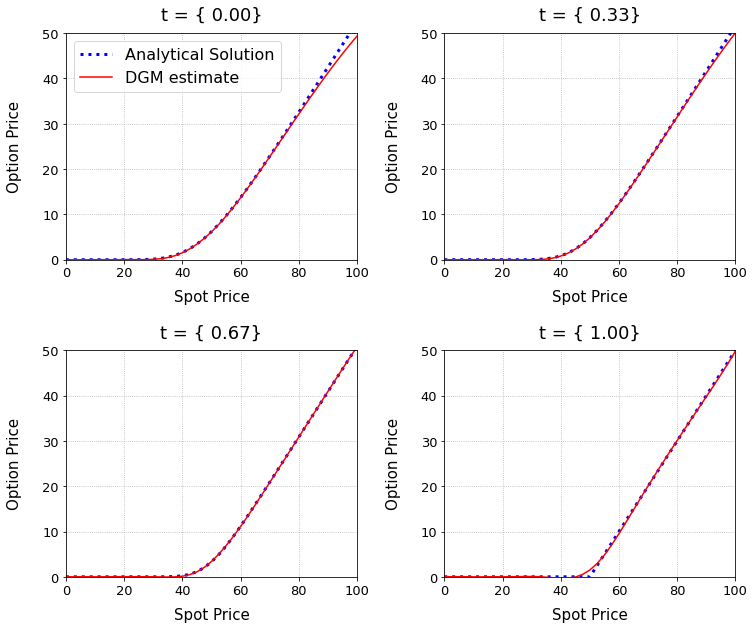

In [ ]:
# SCRIPT FOR SOLVING THE BLACK-SCHOLES EQUATION FOR A EUROPEAN CALL OPTION 

#%% import needed packages
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
import numpy as np
import scipy.stats as spstats
import matplotlib.pyplot as plt

#%% Parameters 
#%% LSTM-like layer used in DGM (see Figure 5.3 and set of equations on p. 45) - modification of Keras layer class

class LSTMLayer(tf.keras.layers.Layer):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, output_dim, input_dim, trans1 = "tanh", trans2 = "tanh"):
        '''
        Args:
            input_dim (int):       dimensionality of input data
            output_dim (int):      number of outputs for LSTM layers
            trans1, trans2 (str):  activation functions used inside the layer; 
                                   one of: "tanh" (default), "relu" or "sigmoid"
        
        Returns: customized Keras layer object used as intermediate layers in DGM
        '''        
        
        # create an instance of a Layer object (call initialize function of superclass of LSTMLayer)
        super(LSTMLayer, self).__init__()
        
        # add properties for layer including activation functions used inside the layer  
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        if trans1 == "tanh":
            self.trans1 = tf.nn.tanh
        elif trans1 == "relu":
            self.trans1 = tf.nn.relu
        elif trans1 == "sigmoid":
            self.trans1 = tf.nn.sigmoid
        
        if trans2 == "tanh":
            self.trans2 = tf.nn.tanh
        elif trans2 == "relu":
            self.trans2 = tf.nn.relu
        elif trans2 == "sigmoid":
            self.trans2 = tf.nn.relu
        
        ### define LSTM layer parameters (use Xavier initialization)
        # u vectors (weighting vectors for inputs original inputs x)
        self.Uz = self.add_variable("Uz", shape=[self.input_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Ug = self.add_variable("Ug", shape=[self.input_dim ,self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Ur = self.add_variable("Ur", shape=[self.input_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Uh = self.add_variable("Uh", shape=[self.input_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        
        # w vectors (weighting vectors for output of previous layer)        
        self.Wz = self.add_variable("Wz", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Wg = self.add_variable("Wg", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Wr = self.add_variable("Wr", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Wh = self.add_variable("Wh", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        
        # bias vectors
        self.bz = self.add_variable("bz", shape=[1, self.output_dim])
        self.bg = self.add_variable("bg", shape=[1, self.output_dim])
        self.br = self.add_variable("br", shape=[1, self.output_dim])
        self.bh = self.add_variable("bh", shape=[1, self.output_dim])
    
    
    # main function to be called 
    def call(self, S, X):
        '''Compute output of a LSTMLayer for a given inputs S,X .    

        Args:            
            S: output of previous layer
            X: data input
        
        Returns: customized Keras layer object used as intermediate layers in DGM
        '''   
        
        # compute components of LSTM layer output (note H uses a separate activation function)
        Z = self.trans1(tf.add(tf.add(tf.matmul(X,self.Uz), tf.matmul(S,self.Wz)), self.bz))
        G = self.trans1(tf.add(tf.add(tf.matmul(X,self.Ug), tf.matmul(S, self.Wg)), self.bg))
        R = self.trans1(tf.add(tf.add(tf.matmul(X,self.Ur), tf.matmul(S, self.Wr)), self.br))
        
        H = self.trans2(tf.add(tf.add(tf.matmul(X,self.Uh), tf.matmul(tf.multiply(S, R), self.Wh)), self.bh))
        
        # compute LSTM layer output
        S_new = tf.add(tf.multiply(tf.subtract(tf.ones_like(G), G), H), tf.multiply(Z,S))
        
        return S_new

#%% Fully connected (dense) layer - modification of Keras layer class
   
class DenseLayer(tf.keras.layers.Layer):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, output_dim, input_dim, transformation=None):
        '''
        Args:
            input_dim:       dimensionality of input data
            output_dim:      number of outputs for dense layer
            transformation:  activation function used inside the layer; using
                             None is equivalent to the identity map 
        
        Returns: customized Keras (fully connected) layer object 
        '''        
        
        # create an instance of a Layer object (call initialize function of superclass of DenseLayer)
        super(DenseLayer,self).__init__()
        self.output_dim = output_dim
        self.input_dim = input_dim
        
        ### define dense layer parameters (use Xavier initialization)
        # w vectors (weighting vectors for output of previous layer)
        self.W = self.add_variable("W", shape=[self.input_dim, self.output_dim],
                                   initializer = tf.contrib.layers.xavier_initializer())
        
        # bias vectors
        self.b = self.add_variable("b", shape=[1, self.output_dim])
        
        if transformation:
            if transformation == "tanh":
                self.transformation = tf.tanh
            elif transformation == "relu":
                self.transformation = tf.nn.relu
        else:
            self.transformation = transformation
    
    
    # main function to be called 
    def call(self,X):
        '''Compute output of a dense layer for a given input X 

        Args:                        
            X: input to layer            
        '''
        
        # compute dense layer output
        S = tf.add(tf.matmul(X, self.W), self.b)
                
        if self.transformation:
            S = self.transformation(S)
        
        return S

#%% Neural network architecture used in DGM - modification of Keras Model class
    
class DGMNet(tf.keras.Model):
    
    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, layer_width, n_layers, input_dim, final_trans=None):
        '''
        Args:
            layer_width: 
            n_layers:    number of intermediate LSTM layers
            input_dim:   spaital dimension of input data (EXCLUDES time dimension)
            final_trans: transformation used in final layer
        
        Returns: customized Keras model object representing DGM neural network
        '''  
        
        # create an instance of a Model object (call initialize function of superclass of DGMNet)
        super(DGMNet,self).__init__()
        
        # define initial layer as fully connected 
        # NOTE: to account for time inputs we use input_dim+1 as the input dimensionality
        self.initial_layer = DenseLayer(layer_width, input_dim+1, transformation = "tanh")
        
        # define intermediate LSTM layers
        self.n_layers = n_layers
        self.LSTMLayerList = []
                
        for _ in range(self.n_layers):
            self.LSTMLayerList.append(LSTMLayer(layer_width, input_dim+1))
        
        # define final layer as fully connected with a single output (function value)
        self.final_layer = DenseLayer(1, layer_width, transformation = final_trans)
    
    
    # main function to be called  
    def call(self,t,x):
        '''            
        Args:
            t: sampled time inputs 
            x: sampled space inputs

        Run the DGM model and obtain fitted function value at the inputs (t,x)                
        '''  
        
        # define input vector as time-space pairs
        X = tf.concat([t,x],1)
        
        # call initial layer
        S = self.initial_layer.call(X)
        
        # call intermediate LSTM layers
        for i in range(self.n_layers):
            S = self.LSTMLayerList[i].call(S,X)
        
        # call final LSTM layers
        result = self.final_layer.call(S)
        
        return result
# Option parameters
r = 0.05           # Interest rate
sigma = 0.25       # Volatility
K = 50             # Strike
T = 1              # Terminal time
S0 = 0.5           # Initial price

# Solution parameters (domain on which to solve PDE)
t_low = 0 + 1e-10    # time lower bound
S_low = 0.0 + 1e-10  # spot price lower bound
S_high = 2*K         # spot price upper bound

# neural network parameters
num_layers = 3
nodes_per_layer = 50
learning_rate = 0.001

# Training parameters
sampling_stages  = 100   # number of times to resample new time-space domain points
steps_per_sample = 10    # number of SGD steps to take before re-sampling

# Sampling parameters
nSim_interior = 1000
nSim_terminal = 100
S_multiplier  = 1.5   # multiplier for oversampling i.e. draw S from [S_low, S_high * S_multiplier]

# Plot options
n_plot = 41  # Points on plot grid for each dimension

# Save options
saveOutput = False
saveName   = 'BlackScholes_EuropeanCall'
saveFigure = False
figureName = 'BlackScholes_EuropeanCall.png'

#%% Black-Scholes European call price

def BlackScholesCall(S, K, r, sigma, t):
    ''' Analytical solution for European call option price under Black-Scholes model 
    
    Args:
        S:     spot price
        K:     strike price
        r:     risk-free interest rate
        sigma: volatility
        t:     time
    ''' 
    
    d1 = (np.log(S/K) + (r + sigma**2 / 2) * (T-t))/(sigma * np.sqrt(T-t))
    d2 = d1 - (sigma * np.sqrt(T-t))

    callPrice = S * spstats.norm.cdf(d1) - K * np.exp(-r * (T-t)) * spstats.norm.cdf(d2)
    
    return callPrice

#%% Sampling function - randomly sample time-space pairs 

def sampler(nSim_interior, nSim_terminal):
    ''' Sample time-space points from the function's domain; points are sampled
        uniformly on the interior of the domain, at the initial/terminal time points
        and along the spatial boundary at different time points. 
    
    Args:
        nSim_interior: number of space points in the interior of the function's domain to sample 
        nSim_terminal: number of space points at terminal time to sample (terminal condition)
    ''' 
    
    # Sampler #1: domain interior
    t_interior = np.random.uniform(low=t_low, high=T, size=[nSim_interior, 1])
    S_interior = np.random.uniform(low=S_low, high=S_high*S_multiplier, size=[nSim_interior, 1])

    # Sampler #2: spatial boundary
        # no spatial boundary condition for this problem
    
    # Sampler #3: initial/terminal condition
    t_terminal = T * np.ones((nSim_terminal, 1))
    S_terminal = np.random.uniform(low=S_low, high=S_high*S_multiplier, size = [nSim_terminal, 1])
    
    return t_interior, S_interior, t_terminal, S_terminal

#%% Loss function for Fokker-Planck equation

def loss(model, t_interior, S_interior, t_terminal, S_terminal):
    ''' Compute total loss for training.
    
    Args:
        model:      DGM model object
        t_interior: sampled time points in the interior of the function's domain
        S_interior: sampled space points in the interior of the function's domain
        t_terminal: sampled time points at terminal point (vector of terminal times)
        S_terminal: sampled space points at terminal time
    ''' 
    
    # Loss term #1: PDE
    # compute function value and derivatives at current sampled points
    V = model(t_interior, S_interior)
    V_t = tf.gradients(V, t_interior)[0]
    V_s = tf.gradients(V, S_interior)[0]
    V_ss = tf.gradients(V_s, S_interior)[0]
    diff_V = V_t + 0.5 * sigma**2 * S_interior**2 * V_ss + r * S_interior * V_s - r*V

    # compute average L2-norm of differential operator
    L1 = tf.reduce_mean(tf.square(diff_V)) 
    
    # Loss term #2: boundary condition
        # no boundary condition for this problem
    
    # Loss term #3: initial/terminal condition
    target_payoff = tf.nn.relu(S_terminal - K)
    fitted_payoff = model(t_terminal, S_terminal)
    
    L3 = tf.reduce_mean( tf.square(fitted_payoff - target_payoff) )

    return L1, L3

#%% Set up network

# initialize DGM model (last input: space dimension = 1)
model = DGMNet(nodes_per_layer, num_layers, 1)

# tensor placeholders (_tnsr suffix indicates tensors)
# inputs (time, space domain interior, space domain at initial time)
t_interior_tnsr = tf.placeholder(tf.float32, [None,1])
S_interior_tnsr = tf.placeholder(tf.float32, [None,1])
t_terminal_tnsr = tf.placeholder(tf.float32, [None,1])
S_terminal_tnsr = tf.placeholder(tf.float32, [None,1])

# loss 
L1_tnsr, L3_tnsr = loss(model, t_interior_tnsr, S_interior_tnsr, t_terminal_tnsr, S_terminal_tnsr)
loss_tnsr = L1_tnsr + L3_tnsr

# option value function
V = model(t_interior_tnsr, S_interior_tnsr)

# set optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_tnsr)

# initialize variables
init_op = tf.global_variables_initializer()

# open session
sess = tf.Session()
sess.run(init_op)

#%% Train network
# for each sampling stage
for i in range(sampling_stages):
    
    # sample uniformly from the required regions
    t_interior, S_interior, t_terminal, S_terminal = sampler(nSim_interior, nSim_terminal)
    
    # for a given sample, take the required number of SGD steps
    for _ in range(steps_per_sample):
        loss,L1,L3,_ = sess.run([loss_tnsr, L1_tnsr, L3_tnsr, optimizer],
                                feed_dict = {t_interior_tnsr:t_interior, S_interior_tnsr:S_interior, t_terminal_tnsr:t_terminal, S_terminal_tnsr:S_terminal})
    
    print(loss, L1, L3, i)

# save outout
if saveOutput:
    saver = tf.train.Saver()
    saver.save(sess, './SavedNets/' + saveName)

#%% Plot results

# LaTeX rendering for text in plots
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

# figure options
plt.figure()
plt.figure(figsize = (12,10))

# time values at which to examine density
valueTimes = [t_low, T/3, 2*T/3, T]

# vector of t and S values for plotting
S_plot = np.linspace(S_low, S_high, n_plot)

for i, curr_t in enumerate(valueTimes):
    
    # specify subplot
    plt.subplot(2,2,i+1)
    
    # simulate process at current t 
    optionValue = BlackScholesCall(S_plot, K, r, sigma, curr_t)
    
    # compute normalized density at all x values to plot and current t value
    t_plot = curr_t * np.ones_like(S_plot.reshape(-1,1))
    fitted_optionValue = sess.run([V], feed_dict= {t_interior_tnsr:t_plot, S_interior_tnsr:S_plot.reshape(-1,1)})
    
    # plot histogram of simulated process values and overlay estimated density
    plt.plot(S_plot, optionValue, color = 'b', label='Analytical Solution', linewidth = 3, linestyle=':')
    plt.plot(S_plot, fitted_optionValue[0], color = 'r', label='DGM estimate')    
    
    # subplot options
    plt.ylim(ymin=0.0, ymax=K)
    plt.xlim(xmin=0.0, xmax=S_high)
    plt.xlabel(r"Spot Price", fontsize=15, labelpad=10)
    plt.ylabel(r"Option Price", fontsize=15, labelpad=20)
    plt.title(r"t = { %.2f}"%(curr_t), fontsize=18, y=1.03)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.grid(linestyle=':')
    
    if i == 0:
        plt.legend(loc='upper left', prop={'size': 16})
    
# adjust space between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.4)

if saveFigure:
    plt.savefig(figureName)